# "Conventional" Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [8]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])
target = "net_migration_tp1"
features = data.drop(["iso3", "year", "set", target], axis=1).columns.tolist()
data = data[data["year"] < 2021]

In [9]:
def collect_metrics(y: np.array, y_hat: np.array) -> dict:
    metrics = {
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "MAE": mean_absolute_error(y, y_hat),
        "R-squared": r2_score(y, y_hat)
    }

    return metrics

In [10]:
train = data[data["set"] == "train"]
val = data[data["set"] == "val"]
test = data[data["set"] == "test"]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

## Lasso-Regression

Lasso-regression with lagged dependent variable, country dummies & year dummies ("two-way fixed-effects").

In [13]:
lasso = Lasso()
lasso_params = {"alpha": np.arange(1e-6, 1e-4, 1e-6)}
#^ while the upper bound for alpha is technically Inf, we saw in testing that the penalty needs to be extremely small.
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
lasso_search.fit(X_train, y_train)
print("Best Alpha:", lasso_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Alpha: {'alpha': 4.9999999999999996e-06}


In [14]:
lasso_best = lasso_search.best_estimator_
y_hat_test_lasso = lasso_best.predict(X_test)

collect_metrics(y_test, y_hat_test_lasso)

{'MSE': 0.00045860848316275655,
 'RMSE': 0.02141514611583952,
 'MAE': 0.007401227380006136,
 'R-squared': 0.3224854407288895}

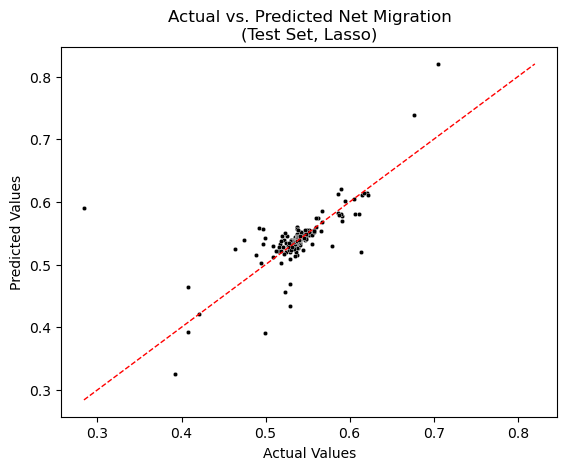

In [15]:
y_hat_test_lasso = lasso_best.predict(X_test)
sns.scatterplot(x=y_test, y=y_hat_test_lasso, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_lasso))
max_val = max(max(y_test), max(y_hat_test_lasso))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, Lasso)")
plt.show()

Most important features (by absolute coefficient):

In [16]:
coefs = pd.DataFrame({
    "feature": X_train.columns,
    "abs_coef": abs(lasso_best.coef_)
})

coefs.sort_values("abs_coef", ascending=False)[:10]

,feature,abs_coef
0,net_migration,0.651165
7,pop_growth,0.122486
213,USA,0.090119
28,BGD,0.029233
46,CHN,0.025557
160,PAK,0.021176
135,MEX,0.020929
16,ARE,0.016815
177,SAU,0.013956
60,DEU,0.013278


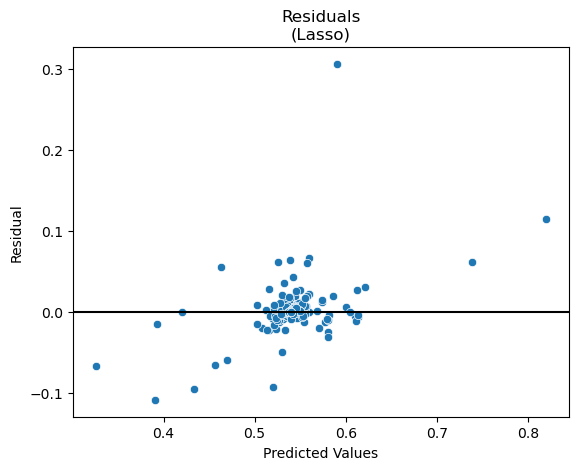

In [17]:
error_lasso = y_hat_test_lasso - y_test
sns.scatterplot(x=y_hat_test_lasso, y=error_lasso)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(Lasso)')
plt.show()

Forward prediction of validation & test set:

In [22]:
def get_forward_pred(model, country: str) -> pd.DataFrame:
    df = data[(data["iso3"] == country) & (data["year"] >= 2000)][["year", "net_migration"]].rename(columns={"net_migration": "actual"})
    predictions = pd.DataFrame({
        "year": [2016, 2017, 2018, 2019, 2020],
        "predicted": [*model.predict(X_val[X_val[country] == 1]), *model.predict(X_test[X_test[country] == 1])]
    })

    df = df.merge(predictions, how="left", on="year")

    return df.melt(id_vars="year", value_vars=["actual", "predicted"], value_name="value", var_name="Values")



In [21]:
val["year"].min()

2016

Text(0.5, 1.0, 'Model predictions\nLasso, USA')

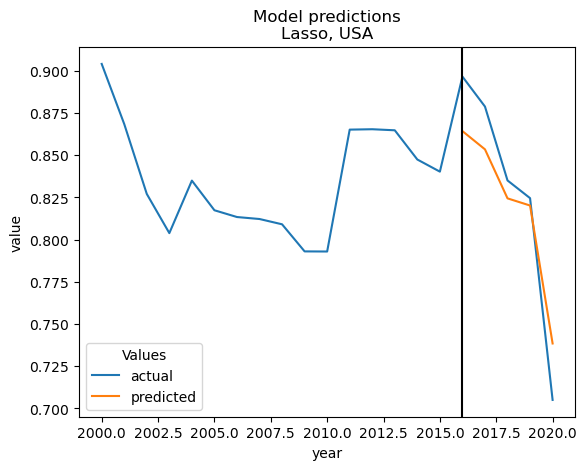

In [25]:
sns.lineplot(
    data=get_forward_pred(lasso_best, "USA"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2016, color="black")
plt.title("Model predictions\nLasso, USA")

Text(0.5, 1.0, 'Model predictions\nLasso, DEU')

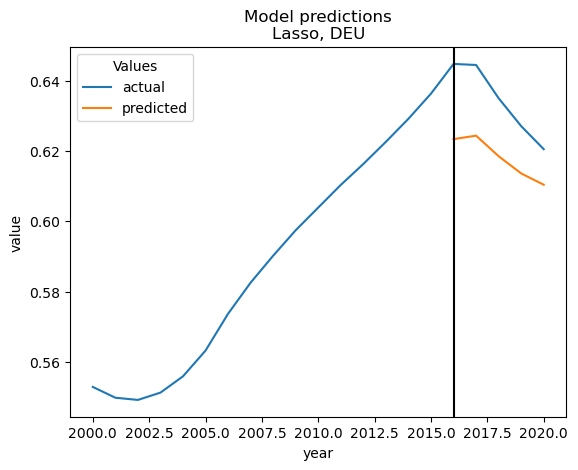

In [27]:
sns.lineplot(
    data=get_forward_pred(lasso_best, "DEU"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2016, color="black")
plt.title("Model predictions\nLasso, DEU")

## XGBoost-Regressor

In [28]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=3,  # reduced folds bc of more hyperparams (-> bigger grid)
    scoring="neg_mean_squared_error",
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [29]:
xgb_best = grid_search.best_estimator_
y_hat_test_xgb = xgb_best.predict(X_test)

In [38]:
collect_metrics(y_test, y_hat_test_xgb)

{'MSE': 0.0006520058770705872,
 'RMSE': 0.025534405751271895,
 'MAE': 0.00795564817135173,
 'R-squared': 0.03677430605032783}

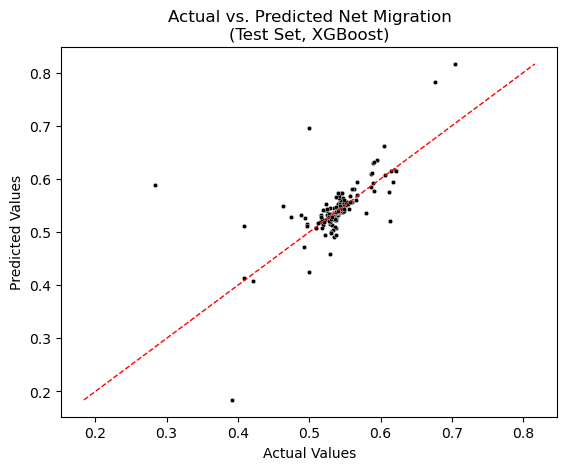

In [39]:
sns.scatterplot(x=y_test, y=y_hat_test_xgb, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_xgb))
max_val = max(max(y_test), max(y_hat_test_xgb))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, XGBoost)")
plt.show()

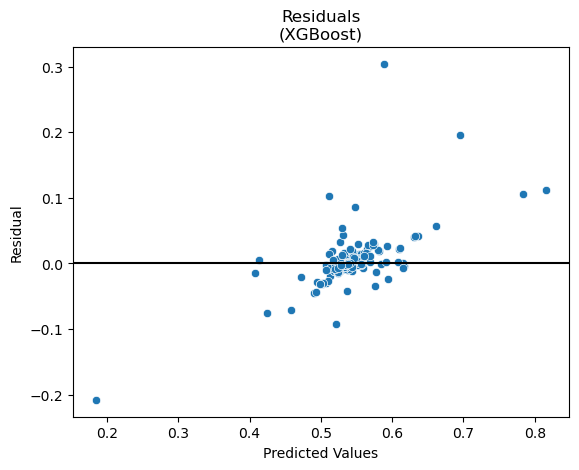

In [32]:
error_xgb = y_hat_test_xgb - y_test
sns.scatterplot(x=y_hat_test_xgb, y=error_xgb)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(XGBoost)')
plt.show()

Text(0.5, 1.0, 'Top 10 most important features\n(XGBoost)')

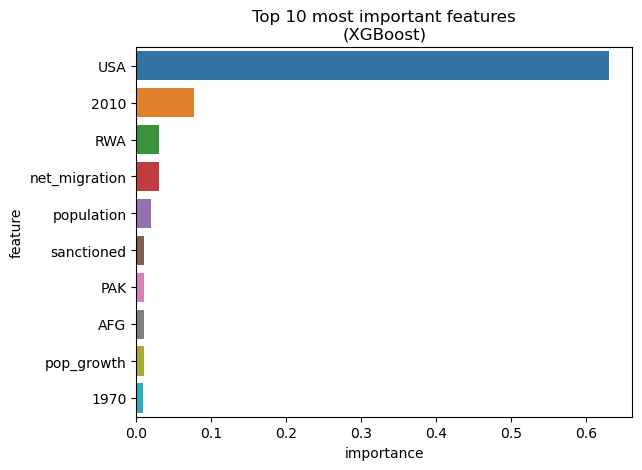

In [33]:
feature_imp = pd.DataFrame({"feature": features, "importance": xgb_best.feature_importances_})
top10_feats = feature_imp.sort_values("importance", ascending=False)[:10]

sns.barplot(
    data=top10_feats,
    x="importance",
    y="feature"
)
plt.title("Top 10 most important features\n(XGBoost)")

# net_migration = net migration in t-1

Text(0.5, 1.0, 'Model predictions\nUSA, XGBoost')

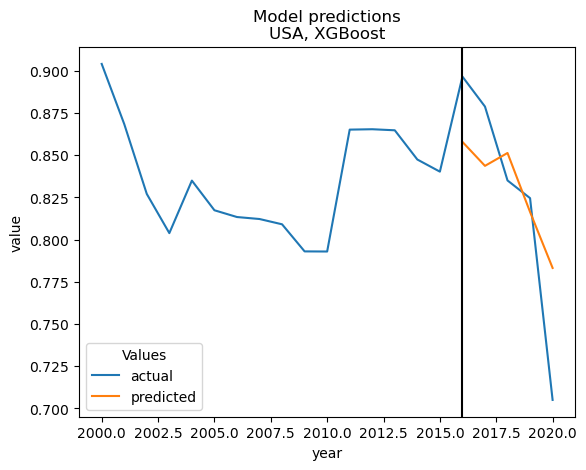

In [36]:
sns.lineplot(
    data=get_forward_pred(xgb_best, "USA"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2016, color="black")
plt.title("Model predictions\nUSA, XGBoost")

Text(0.5, 1.0, 'Model predictions\nDEU, XGBoost')

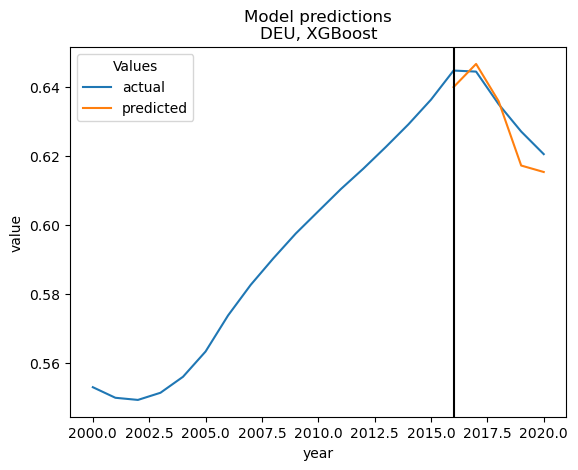

In [37]:
sns.lineplot(
    data=get_forward_pred(xgb_best, "DEU"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2016, color="black")
plt.title("Model predictions\nDEU, XGBoost")